In [76]:
%load_ext autoreload
%autoreload 2
from agent_configs import make_agent
#from training import run_training, train_reps, train_or_load_condition
from eval_funcs import avg_stats, eval_holdout_stats, eval_total_cert_stats

def gauss(data, filters=[(0,100,1.0)]):
    data = data.copy()
    if(isinstance(filters, float)):
        filters = [(0,-1,filters)]
    from scipy.ndimage import gaussian_filter1d
    for (st, en, sig) in filters:
        if(sig == 0): continue
        l = len(data) 
        en = max(en,l) if en != -1 else en
        if(l > st and sig > 0.0):
            data[st:en] = gaussian_filter1d(data[st:en],sigma=sig)
    return data       
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import pickle
import os
import warnings

# Replace [0] darken old blue #1f77b4 (For Tritanopia blue-green)
# Replace [2] lighten old green #2ca02c (For Deuteranopia red-green)
# Replace [3] darken old red #d62728 (For Deuteranopia red-green)q
colors = ['#1c6ca3', '#ff7f0e', '#2fac2f', '#cb2525', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
print(plt.rcParams['axes.prop_cycle'].by_key()['color'])

cond_colors = {
    "stand_p_e_l" : colors[4],
    "stand" : colors[1], # Orange
    
    "decision_tree" : colors[0],
    "neural_net" : colors[5],
    "random_forest" : colors[3],
    "xg_boost" : colors[2],
    "xg_boost_active" : colors[2],
    
    "stand_p" : colors[8],
    "stand_p_e" : colors[6],
    
    "stand_p_e_l_active" : colors[4],
    "stand_p_l" : colors[4],
    "stand_p_e_l_SC" : colors[1],
    "stand_p_e_l_SC_active" : colors[1],
    
    "stand_p00_e_l" : colors[1],
    "stand_p05_e_l" : colors[2],
    "stand_p1_e_l" : colors[3],
    "stand_p5_e_l" : colors[9],
    "stand_p10_e_l" : colors[5],
    "stand_p25_e_l" : colors[6],
    "stand_p50_e_l" : colors[4],
    "stand_p100_e_l" : colors[8],
    
    "stand_p_e00_l" : colors[1],
    "stand_p_e05_l" : colors[2],
    "stand_p_e1_l" : colors[3],
    "stand_p_e5_l" : colors[4],
    "stand_p_e10_l" : colors[5],
    "stand_p_e25_l" : colors[6],
    "stand_p_e50_l" : colors[8],
    "stand_p_e100_l" : colors[9],
    
    "stand_p_e_l5" : colors[1],
    "stand_p_e_l10" : colors[5],
    "stand_p_e_l25" : colors[6],
    "stand_p_e_l50" : colors[8],
    "stand_p_e_l100" : colors[9],
    
    "stand_sl0" : colors[1],
    "stand_sl5" : colors[4],
    "stand_sl10" : colors[5],
    "stand_sl15" : colors[9],
    "stand_sl20" : colors[6],
    "stand_sl25" : colors[8],
    #"stand_sl30" : colors[8],
    #"stand_sl40" : colors[9],
    #"stand_sl50" : colors[4],
    
    "stand_dyn" : colors[1], # Orange
    "stand_max" : colors[8],
    "stand_near" : colors[4],
    "stand_w_slip" : colors[3],
}

cond_labels = {
    "decision_tree" : "Decision Tree",
    "random_forest" : "Random Forest",
    "xg_boost" : "XGBoost",
    "stand" : "STAND",
    "stand_p_e_l" : "STAND (hier. shrink)",
    "neural_net" : "Neural Net"
}

cond_marker_props = {
    #"stand_p5_e_l" : {"marker" : "^", "markersize" : 6, "markevery" : 5}, #(0,5)},
    "stand" : {"marker" : "^", "markersize" : 6, "markevery" : 5},#[0,19,39,59,79, -1]}, #(0,5)},
    "stand_p_e_l" : {"marker" : "+", "markersize" : 6, "markevery" : 5},#[0,19,39,59,79, -1]}, #(0,5)},
    "random_forest" : {"marker" : ".", "markersize" : 8, "markevery" : 5},#[0,19,39,59,79, -1]},#(0,5)},
    "decision_tree" : {"linestyle" : "--"},
    "neural_net" : {"linestyle" : "dashdot"},
    
    "stand_p_e_l_active" : {"linestyle" : "--"},
    "stand_p_e_l_SC_active" : {"linestyle" : "--"},
    "xg_boost_active" : {"linestyle" : "--"},
    
    "stand_p00_e_l" : {"marker" : "^", "markersize" : 6, "markevery" : 10},
    "stand_p05_e_l" : {"linestyle" : "--"},
    "stand_p1_e_l" : {"linestyle" : "--"},
    "stand_p5_e_l" : {"linestyle" : "--"},
    "stand_p10_e_l" : {"linestyle" : "--"},
    "stand_p25_e_l" : {"linestyle" : "--"},
    "stand_p50_e_l" : {"marker" : "o", "markersize" : 6, "markevery" : 10},
}

def load_stat_sets(file_pattern):
    stat_sets_by_model = {}
    for file_name in glob(file_pattern):
        with open(file_name, 'rb') as f:
            stats_by_model = pickle.load(f)
            for model_name, stats in stats_by_model.items():
                if(model_name == "rand_forest"):
                    model_name = "random_forest"
                if(model_name == "xgboost"):
                    model_name = "xg_boost"
                stats_list = stat_sets_by_model.get(model_name, [])
                stats_list.append(stats)
                stat_sets_by_model[model_name] = stats_list
    return stat_sets_by_model

def aggregate_stat(stat_sets_by_model, stat_name, agg_fn = np.nanmean, filt=None):
    out = {}
    for model_name, stats_list in stat_sets_by_model.items():
        #print([["prod_monot" in x] for x in stats_list])
        stat_vals = [x[stat_name] for x in stats_list if stat_name in x]
        if(filt):
            filt_name, filt_fn = filt
            filt_vals = [x[filt_name] for x in stats_list if filt_name in x]
            #print(stat_vals)
            #print(filt_vals)
            stat_vals = [(x if filt_fn(f) else np.nan) for x,f in zip(stat_vals, filt_vals)]
        
        if(len(stat_vals) == 0):
            continue
            
        if(isinstance(stat_vals[0], np.ndarray)):
            max_len = max([len(x) for x in stat_vals])
            stat_vals = np.array([np.pad(x, ((0, max_len-len(x))), mode='constant', constant_values=np.nan) for x in stat_vals])
            stat_vals = np.stack(stat_vals)
            
        with warnings.catch_warnings():
            stat_vals = np.array(stat_vals)
            agg = agg_fn(stat_vals, axis=0) if not np.all(np.isnan(stat_vals)) else np.nan
        
        #if(isinstance(agg, np.ndarray)):
        #    agg = gauss(agg)
        #print(type(agg), stat_vals.shape)
        out[model_name] = agg
        
        #print(agg)
    return out

def aggregate_active_utility(stat_sets_by_model, stat_name, stat_max=1):
    out = {}
    for model_name, stats_list in stat_sets_by_model.items():
        #print([["prod_monot" in x] for x in stats_list])
        vals = [x[stat_name] for x in stats_list if stat_name in x]
        
        
        active_name = model_name + "_active"
        #print(active_name, active_name in curve_by_model)
        if(active_name in stat_sets_by_model):
            active_stat_list = stat_sets_by_model[active_name]
            a_vals = [x[stat_name] for x in active_stat_list if stat_name in x]
        else:
            continue
            #curve_pairs[model_name] = (curve, curve_by_model[active_name])

        if(len(vals) == 0):
            continue
        #print(model_name)
        
        norm_vals = []
        for v,a in zip(vals, a_vals):
            v = np.array(v)
            a = np.array(a)
            with np.errstate(divide='ignore', invalid='ignore'):
                #print(a-v)
                den = (stat_max-np.min([a,v], axis=0))
                nv = np.where(np.abs(den) > 1e-6, (a-v) / den, 1.0)
                norm_vals.append(nv)
                #print("v:", v)
                #print("a:", a)
                #print("nv:", nv)
            
        with warnings.catch_warnings():
            agg = np.nanmean(np.array(norm_vals), axis=0)
        agg = gauss(agg)
        #print(type(agg), stat_vals.shape)
        out[model_name] = agg
        
        #print(agg)
    return out
        
def plot_stat(curve_by_model, title=None, skip=[], y_lim=None, x_lim=(-2,102), h_line=None,
              y_label=None, x_label="Number of Examples", save_name=None, show_active=False,
              smooth=2.0):
    plt.figure(figsize=(6,3.25))
    
    #title = title if title else stat
    
    for model_name, curve in curve_by_model.items():
        if(not show_active and "_active" in model_name):
            continue
        label = cond_labels.get(model_name, model_name)
        color = cond_colors.get(model_name, "grey")
        marker_props = cond_marker_props.get(model_name, {})
        plt.plot(np.arange(1,len(curve)+1), gauss(curve*100, smooth), color=color, 
                 label=label, **marker_props)
    plt.grid()
    plt.title(title)
    plt.legend(fontsize=9)    
    if(h_line is not None): plt.hlines(h_line, *x_lim, linestyle='--', color="#999")
    if(x_lim): plt.xlim(*x_lim)
    if(y_lim): plt.ylim(*y_lim)
    if(x_label): plt.xlabel(x_label)
    if(y_label): plt.ylabel(y_label)
    
    if(save_name): 
        os.makedirs("sim_plots", exist_ok=True)
        plt.savefig(f"sim_plots/{save_name}.png", bbox_inches='tight')
        plt.savefig(f"sim_plots/{save_name}.pdf", bbox_inches='tight', format='pdf')
    plt.show()
    
def plot_active_diff(curve_by_model, title=None, skip=[], y_lim=None, x_lim=(-2,102), h_line=None,
                    y_label=None, x_label="Number of Examples", save_name=None):
    plt.figure(figsize=(6,4))
        
    curve_pairs = {}
    for model_name, curve in curve_by_model.items():
        active_name = model_name + "_active"
        print(active_name, active_name in curve_by_model)
        if(active_name in curve_by_model):
            curve_pairs[model_name] = (curve, curve_by_model[active_name])
            
    for model_name, (curve, a_curve) in curve_pairs.items():        
        label = cond_labels.get(model_name, model_name)
        color = cond_colors.get(model_name, "grey")
        marker_props = cond_marker_props.get(model_name, {})
        
        d_curve = ((a_curve-curve)/(1-curve))
        print((1-curve))
        
        plt.plot(np.arange(1,len(d_curve)+1), gauss(d_curve*100), color=color, 
                 label=label, **marker_props)
            
    plt.grid()
    plt.title(title)
    plt.legend()    
    if(h_line is not None): plt.hlines(h_line, *x_lim, linestyle='--', color="#999")
    if(x_lim): plt.xlim(*x_lim)
    if(y_lim): plt.ylim(*y_lim)
    if(x_label): plt.xlabel(x_label)
    if(y_label): plt.ylabel(y_label)
    
    if(save_name): 
        os.makedirs("sim_plots", exist_ok=True)
        plt.savefig(f"sim_plots/{save_name}.png", bbox_inches='tight')
        plt.savefig(f"sim_plots/{save_name}.pdf", bbox_inches='tight', format='pdf')
    plt.show()
    
def print_stats(stat_sets_by_model, stat_name, title=None, big_better=True, index=None):
    title = title if title else name
    
    print(f"{title}:")
    with warnings.catch_warnings():
        if(index is None):
            d = {name : np.nanmean(np.array([x[stat_name] for x in stats if stat_name in x]),axis=0) 
                 for name, stats in stat_sets_by_model.items() if stat_name in stats[0]}
        else:
            
            d = {name : np.nanmean(np.array([x[stat_name][index] for x in stats if stat_name in x]),axis=0) 
                 for name, stats in stat_sets_by_model.items() if stat_name in stats[0]}
        
    best_ind = np.argmax([d if big_better else -d for d in d.values()])
    for i, (model_name, val) in enumerate(d.items()):
        #when, proc = cond
        bold = best_ind == i
        pre = "\033[1m" if bold else ""
        post = "\033[0m" if bold else ""
        print(f"  {model_name}: {pre}{val*100:.2f}%{post}")



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


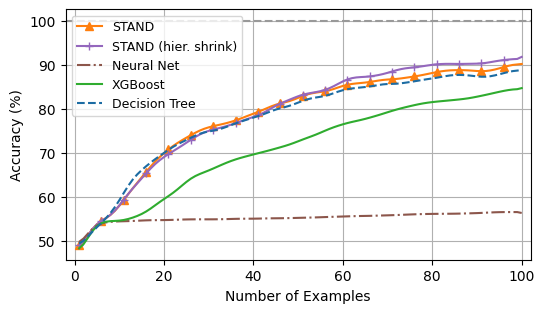

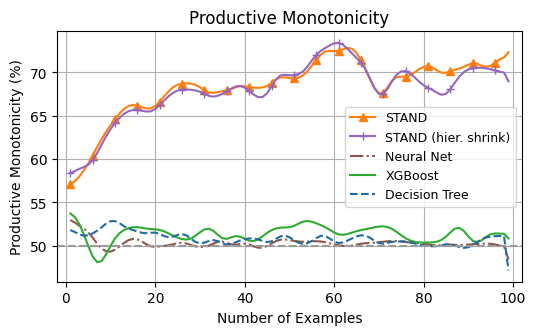

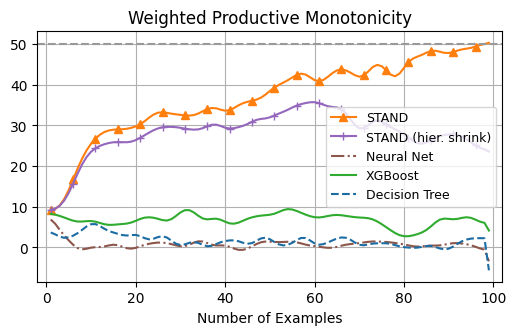

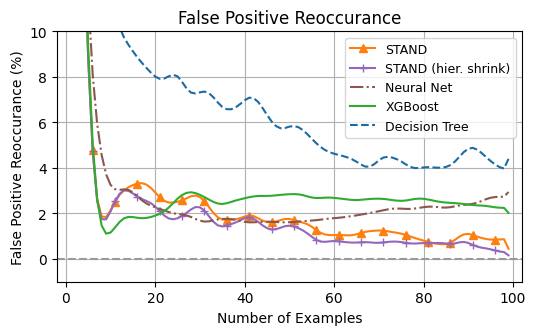

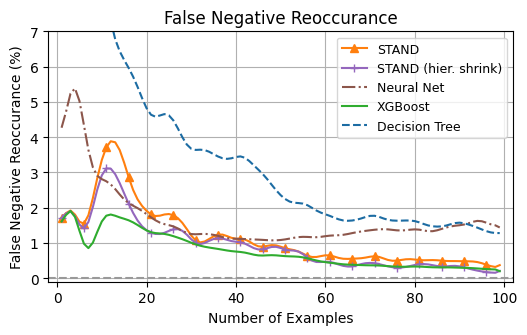

In [94]:
stat_sets_by_model = load_stat_sets("sim_saves/*")

plot_stat( aggregate_stat(stat_sets_by_model, "accuracies"),
           None, h_line=100, show_active=False, y_label="Accuracy (%)", save_name="acc")
plot_stat( aggregate_stat(stat_sets_by_model, "prod_monot"),
           "Productive Monotonicity", h_line=50, y_label="Productive Monotonicity (%)", save_name="prod_monot")
plot_stat( aggregate_stat(stat_sets_by_model, "w_prod_monot"),
           "Weighted Productive Monotonicity", h_line=50)
plot_stat(aggregate_stat(stat_sets_by_model, "FP_reocc"),
          "False Positive Reoccurance", y_lim=(-1,10), h_line=0, y_label="False Positive Reoccurance (%)", 
          save_name="fp_reoc")
plot_stat(aggregate_stat(stat_sets_by_model, "FN_reocc"),
          "False Negative Reoccurance", y_lim=(-.1,7), h_line=0, y_label="False Negative Reoccurance (%)",
          save_name="fn_reoc")

In [99]:
#print_stats(stat_sets_by_model, "accuracies", "Accuracy prob=20", True, index=19)
#print_stats(stat_sets_by_model, "accuracies", "Accuracy prob=50", True, index=49)
#print_stats(stat_sets_by_model, "accuracies", "Accuracy prob=100", True, index=99)
print()
print_stats(stat_sets_by_model, "total_prod_monot", "Total Productive Monotonicity")
print_stats(stat_sets_by_model, "total_error_reocc", "Total Error Reoccurance", False)
print_stats(stat_sets_by_model, "total_FN_reocc", "Total Comission Reoccurance", False)
print_stats(stat_sets_by_model, "total_FP_reocc", "Total Omission Reoccurance", False)
print_stats(stat_sets_by_model, "avg_abs_prec_res", "Average Absolute Precision Residual", False)
print()

#stat_sets_w_o_dt = {k:v for k,v in stat_sets_by_model.items() if k != "decision_tree"}
#print_stats(stat_sets_w_o_dt, ("TN_n",(.50, .51)), "Total Precision @55% +/-5%", True)
#print_stats(stat_sets_w_o_dt, ("total_precision",(.60, .7)), "Total Precision @65% +/-5%", True)
#print_stats(stat_sets_w_o_dt, ("total_precision",(.70, .8)), "Total Precision @75% +/-5%", True)
#print_stats(stat_sets_w_o_dt, ("total_precision",(.80, .9)), "Total Precision @85% +/-5%", True)
#print_stats(stat_sets_w_o_dt, ("total_precision",(.90, .92)), "Total Precision @91% +/-1%", True)
#print_stats(stat_sets_w_o_dt, ("total_precision",(.92, .94)), "Total Precision @93% +/-1%", True)
#print_stats(stat_sets_w_o_dt, ("total_precision",(.94, .96)), "Total Precision @95% +/-1%", True)
#print_stats(stat_sets_w_o_dt, ("total_precision",(.96, .98)), "Total Precision @96% +/-1%", True)
#print_stats(stat_sets_w_o_dt, ("total_precision",(.98, 1.0)), "Total Precision @97% +/-1%", True)
print_stats(stat_sets_by_model, ("total_precision",(1.0, 1.0)), "Total Precision @100% +/-1%", True)


Total Productive Monotonicity:
  stand: 62.49%
  stand_active: 62.38%
  stand_p_e_l: 62.20%
  stand_p_e_l_active: 61.89%
  neural_net: 50.62%
  neural_net_active: 50.91%
  xg_boost: 53.61%
  xg_boost_active: 53.59%
  decision_tree: 52.61%
Total Error Reoccurance:
  stand: 1.82%
  stand_active: 2.09%
  stand_p_e_l: 1.54%
  stand_p_e_l_active: 2.12%
  neural_net: 2.39%
  neural_net_active: 1.90%
  xg_boost: 1.94%
  xg_boost_active: 1.66%
  decision_tree: 5.43%
Total Comission Reoccurance:
  stand: 1.16%
  stand_active: 1.42%
  stand_p_e_l: 0.93%
  stand_p_e_l_active: 1.46%
  neural_net: 1.68%
  neural_net_active: 1.26%
  xg_boost: 0.75%
  xg_boost_active: 0.65%
  decision_tree: 3.85%
Total Omission Reoccurance:
  stand: 2.61%
  stand_active: 2.88%
  stand_p_e_l: 2.29%
  stand_p_e_l_active: 2.90%
  neural_net: 3.27%
  neural_net_active: 2.70%
  xg_boost: 3.33%
  xg_boost_active: 2.83%
  decision_tree: 7.48%
Average Absolute Precision Residual:
  stand: 14.58%
  stand_active: 13.84%
  sta

[(0.5, 0.52), (0.52, 0.54), (0.54, 0.56), (0.56, 0.58), (0.58, 0.6), (0.6, 0.62), (0.62, 0.64), (0.64, 0.66), (0.66, 0.6799999999999999), (0.6799999999999999, 0.7), (0.7, 0.72), (0.72, 0.74), (0.74, 0.76), (0.76, 0.78), (0.78, 0.8), (0.8, 0.8200000000000001), (0.8200000000000001, 0.8400000000000001), (0.8400000000000001, 0.86), (0.86, 0.88), (0.88, 0.9), (0.9, 0.9199999999999999), (0.9199999999999999, 0.94), (0.94, 0.96), (0.96, 0.98), (0.98, 1.0), (1.0, 1.0)]


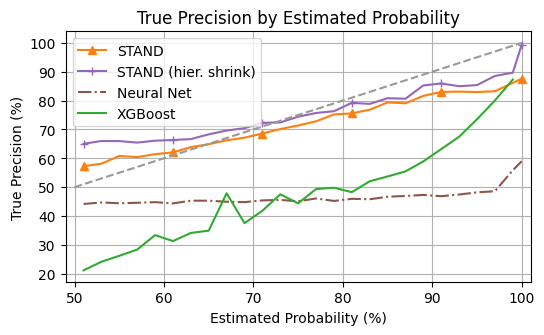

In [91]:

#DEFAULT_CERT_BINS = [( .5+(.01*(i)), .5+(.01*(i+1)) ) for i in range(50)]+[(1.0,1.0)]
DEFAULT_CERT_BINS = [( .5+(.02*(i)), .5+(.02*(i+1)) ) for i in range(25)]+[(1.0,1.0)]
#DEFAULT_CERT_BINS = [( .0+(.01*(i)), .0+(.01*(i+1)) ) for i in range(100)]+[(1.0,1.0)]
print(DEFAULT_CERT_BINS)

def plot_prec(bin_means, curve_by_model, title=None, skip=[], y_lim=None, x_lim=(49,101), h_line=None,
              line=None, smooth=0.0,
              x_label="Estimated Probability (%)", y_label="True Precision (%)", save_name=None, show_active=False):
    
    plt.figure(figsize=(6,3.25))
    
    title = title if title else stat
    
    for model_name, curve in curve_by_model.items():
        if(not show_active and "_active" in model_name):
            continue
        label = cond_labels.get(model_name, model_name)
        color = cond_colors.get(model_name, "grey")
        marker_props = cond_marker_props.get(model_name, {})
        plt.plot(bin_means*100, curve*100, color=color, 
                 label=label, **marker_props)
    plt.grid()
    plt.title(title)
    plt.legend()    
    if(line is not None): plt.plot([x[0] for x in line], [x[1] for x in line], linestyle='--', color="#999")
    if(h_line is not None): plt.hlines(h_line, *x_lim, linestyle='--', color="#999")
    if(x_lim): plt.xlim(*x_lim)
    if(y_lim): plt.ylim(*y_lim)
    if(x_label): plt.xlabel(x_label)
    if(y_label): plt.ylabel(y_label)
    
    if(save_name): 
        os.makedirs("sim_plots", exist_ok=True)
        plt.savefig(f"sim_plots/{save_name}.png", bbox_inches='tight')
        plt.savefig(f"sim_plots/{save_name}.pdf", bbox_inches='tight', format='pdf')
    plt.show()

def plot_precision_curve(stat_sets_by_model,**kwargs):
    res_by_model = {k:np.nan*np.ones(len(DEFAULT_CERT_BINS)) for k in stat_sets_by_model}
    prec_by_model = {k:np.nan*np.ones(len(DEFAULT_CERT_BINS)) for k in stat_sets_by_model}
    bin_means = np.empty(len(DEFAULT_CERT_BINS))
    for i, cert_bin in enumerate(DEFAULT_CERT_BINS):
        c_min, c_max = cert_bin
        c_mean = (c_min + c_max) / 2
        c_hrng = (c_max - c_min) / 2
        #print(cert_bin)
        prec = aggregate_stat(stat_sets_by_model, ('total_precision', cert_bin), np.nanmean,
                              (('bin_n', cert_bin), lambda x: x >= 20))
        #TP_n = aggregate_stat(stat_sets_by_model, ('TP_n', cert_bin), np.sum, (()))
        #bin_n = aggregate_stat(stat_sets_by_model, ('bin_n', cert_bin), np.sum)
        #prec = {k:TP_n[k]/bin_n[k] for k in TP_n}    


        bin_means[i] = c_mean
        for k,p in prec.items():
            res_by_model[k][i] = p-c_mean
            prec_by_model[k][i] = p
    
#print(prec_by_model)

    plot_prec(bin_means, prec_by_model, line=[(50,50),(100,100)], **kwargs)

    
stat_sets_by_model = load_stat_sets("sim_saves/*")
stat_sets_pred_models = {k:v for k,v in stat_sets_by_model.items() if not any(x in k for x in ["VSSM", "decision_tree"])}

plot_precision_curve(stat_sets_pred_models,
                     title="True Precision by Estimated Probability", save_name='prec')
    #prec = stats[('total_precision', cert_bin)]
    #TP_n = stats[('TP_n', cert_bin)]
    #bin_n = stats[('bin_n', cert_bin)]

#plot_stat(aggregate_active_utility(stat_sets_by_model, "accuracies"),
#                  "Active Learning Utility", h_line=100)


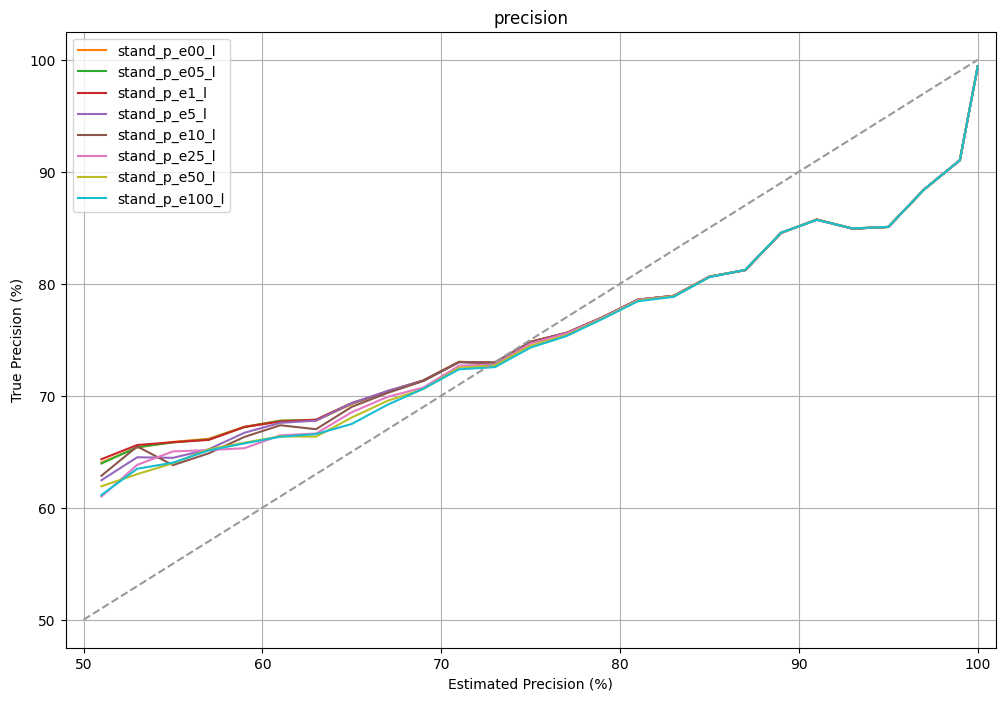

In [5]:
plot_precision_curve(load_stat_sets("e_hyper/*"))

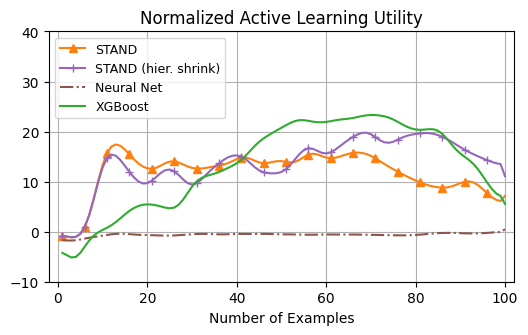

In [97]:
stat_sets_by_model = load_stat_sets("sim_saves/*")

#plot_active_diff( aggregate_stat(stat_sets_by_model, "accuracies"),
#                  "Active Learning Utility", h_line=100)
plot_stat(aggregate_active_utility(stat_sets_by_model, "accuracies"),
                  "Normalized Active Learning Utility", y_lim=(-10,40), save_name="act_lrn")

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from gen_synth_conds import gen_synthetic_dnf_data, print_dnf
from numpy.random import poisson
from numba import njit
import seaborn as sns

min_one_possion = lambda x : 1+poisson(x-1)
min_two_possion = lambda x : 2+poisson(x-2)


@njit(cache=True)
def categorical_corr(X):
    N, M = X.shape
    corr = np.zeros((X.shape[1], X.shape[1]), dtype=np.float64)
    for i in range(M):
        for j in range(M):
            corr[i,j] = np.sum(X[:, i] == X[:, j]) / N
    return corr

def zero_true_lits(correlation_matrix, dnf):
    for conj in dnf:
        for lit in conj:
            ind = lit['ind']
            correlation_matrix[ind, ind] = 0.0
            
def plot_co_occurance_matrix(X,y, dnf):
    Xy = np.concatenate([X,y.reshape(-1,1)], axis=1)


    #correlation_matrix = np.corrcoef(X.T)

    co_occurance_matrix = categorical_corr(Xy)


            
    zero_true_lits(co_occurance_matrix, dnf)

    #print(co_occurance_matrix.shape)
    #import numpy as np
    #import matplotlib.pyplot as plt


    plt.figure(figsize=(20, 14))  # Adjust size as needed
    plt.imshow(X, cmap='viridis')
    # Add a colorbar
    #plt.colorbar()

    pallette = sns.color_palette("vlag", as_cmap=True)
    sns.heatmap(co_occurance_matrix, annot=False, cmap=pallette)#, fmt=".2f",
    #            xticklabels=[f"Var{i}" for i in range(X.shape[1])],
    #            yticklabels=[f"Var{i}" for i in range(X.shape[1])])
    plt.title("Correlation Matrix")
    plt.show()


    
X, y, dnf = gen_synthetic_dnf_data(
                          n_samples=2200,
                          n_feats=50,
                          vals_per_feat= lambda : min_two_possion(3),
                          pos_prop=.5,

                          conj_len= lambda : min_one_possion(5), 
                          num_conj= lambda : min_two_possion(2),
                          dupl_lit_prob=0.3,
                          conj_probs=.28,

                          neg_conj_len=lambda : min_two_possion(4),
                          num_neg_conj=100,
                          neg_dupl_lit_prob=0.3,
                          neg_conj_overlap=.3,

                          force_same_vals=False)
print_dnf(dnf)
plot_co_occurance_matrix(X,y,dnf)


print("=1 Prop", np.sum(y==1)/len(y), np.sum(y==1)/len(y))

X, y, dnf = gen_synthetic_dnf_data(
                          n_samples=2200,
                          n_feats=50,
                          vals_per_feat= lambda : min_two_possion(3),
                          pos_prop=.5,

                          conj_len= lambda : min_one_possion(5), 
                          num_conj= lambda : min_two_possion(2),
                          dupl_lit_prob=0.2,
                          conj_probs=.28,

                          #neg_conj_len=lambda : min_two_possion(3),
                          num_neg_conj=0,
                          #neg_dupl_lit_prob=0.1,
                          #neg_conj_probs=.8,

                          force_same_vals=False)

print_dnf(dnf)
plot_co_occurance_matrix(X,y,dnf)







TypeError: gen_synthetic_dnf_data() got an unexpected keyword argument 'neg_conj_overlap'

In [ ]:
ph_stat_sets_by_model = load_stat_sets("p_hyper/*")

plot_stat( aggregate_stat(ph_stat_sets_by_model, "accuracies"),
           "Test Set Accuracy", h_line=100, show_active=False)
plot_stat( aggregate_stat(ph_stat_sets_by_model, "prod_monot"),
           "Productive Monotonicity", h_line=50)
plot_stat( aggregate_stat(ph_stat_sets_by_model, "w_prod_monot"),
           "Weighted Productive Monotonicity", h_line=50)
plot_stat(aggregate_stat(ph_stat_sets_by_model, "FP_reocc"),
          "False Positive Reoccurance", y_lim=(-1,5), h_line=0, save_name="mc_oms")
plot_stat(aggregate_stat(ph_stat_sets_by_model, "FN_reocc"),
          "False Negative Reoccurance", y_lim=(-.1,2), h_line=0, save_name="frac_oms")

In [ ]:
eh_stat_sets_by_model = load_stat_sets("e_hyper/*")

plot_stat( aggregate_stat(eh_stat_sets_by_model, "accuracies"),
           "Test Set Accuracy", h_line=100, show_active=False)
plot_stat( aggregate_stat(eh_stat_sets_by_model, "prod_monot"),
           "Productive Monotonicity", h_line=50)
plot_stat( aggregate_stat(eh_stat_sets_by_model, "w_prod_monot"),
           "Weighted Productive Monotonicity", h_line=50)
plot_stat(aggregate_stat(eh_stat_sets_by_model, "FP_reocc"),
          "False Positive Reoccurance", y_lim=(-1,5), h_line=0, save_name="mc_oms")
plot_stat(aggregate_stat(eh_stat_sets_by_model, "FN_reocc"),
          "False Negative Reoccurance", y_lim=(-.1,2), h_line=0, save_name="frac_oms")